In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
#importing machine learning libraries
import pickle
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report 

# for hyperparamter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.feature_selection import SelectKBest, chi2

#importing classifiers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# pandas profilling for fast data understanding
from pandas_profiling import ProfileReport

plt.style.use( 'ggplot') # the plots style

# fixing random seed for consistency
random_state = 1

In [ ]:
original = pd.read_csv('../input/cardiovascular-disease-dataset/cardio_train.csv', delimiter = ';')
original

In [ ]:
original.info()

seeing models performance on the default data 

In [ ]:
#splitting the data into train and test set with the taget variable seperated 
X_train , X_test, y_train, y_test = train_test_split(original.drop('cardio',axis = 1), original.cardio, test_size  = 0.2 , random_state = random_state)

In [ ]:
len(X_test) / len(X_train)

In [ ]:
#creating an array of models
models = []

models.append(("RF",RandomForestClassifier(n_jobs = -1  )))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",XGBClassifier(n_jobs=-1)))
models.append(("KNN",KNeighborsClassifier()))

In [ ]:
#measuring the accuracy of each model using simple 3 folds cross validation
for name, model in models :
  kfold = KFold(n_splits = 3 , random_state =random_state  )
  cv_results = cross_val_score(model ,X_train,y_train ,cv = kfold , n_jobs=-1 , scoring='accuracy')
  print(name , (cv_results[0] + cv_results[1] +cv_results[2])/3 )

RF 0.7243571428571429

Dtree 0.6337142857142857

XGB 0.734547619047619

KNN 0.5564523809523809

In [ ]:
rm = RandomForestClassifier(n_jobs = -1 ,random_state=random_state )
rm.fit(X_train , y_train)
preds = rm.predict(X_test)
print("Random forest accuracy is : " , " " , accuracy_score(preds , y_test) )

the default accuracy is `0.7283571428571428`

In [ ]:
data = original.copy() # to keep a refrence to the original data

# Data understanding and cleaning

Pandas profilling report

In [ ]:
pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
profile = ProfileReport(data, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile

1) the age is in days so i will convert it into years to reduce the variance

In [ ]:
original.age.hist(bins = 50)

In [ ]:
data.age = round(data.age / 365)

In [ ]:
data.age.hist(bins = 50)

2) The gender is in 1 and 2 and 1 is more frequent than 2

In [ ]:
plt.figure(figsize=(20,6))
sns.countplot(x='height', hue='gender', data = data, palette="Set2");

it's clear that 2 for men and 1 for women

3) there are outliers in the height

In [ ]:
print(data.height.describe())
sns.boxplot(data.height)

In [ ]:
len(data[data.height > 200]) # how many person has height greater than 200 ? 

In [ ]:
len(data[data.height < 100]) # how many person has height less than 100 ? 

In [ ]:
data = data[(data.height > 100) & (data.height <= 200)]  # removing them as they are not a lot 

In [ ]:
print(data.height.describe())
sns.boxplot(data.height)

In [ ]:
len(data[data.height < 140]) # how many person has height less than 140 ? 

we will leave these now to be conservative until the base model

4) there are clear outliers in the weight

In [ ]:
print(data.height.describe())
sns.boxplot(data.weight)

In [ ]:
print(len(data[data.weight < 40])) # how many person has weight less than 50 ? 
print(len(data[data.weight > 200])) # how many person has height greater than or equal than 200 ? 
print(len(data))

In [ ]:
# removing them 
data = data[(data.weight >= 40) & (data.weight < 200 )]
print(len(data))

In [ ]:
print(data.height.describe())
sns.boxplot(data.weight)

5) handling wronge values in ap_high and ap_low

Blood pressure usually ranges between 90 to 250 for the top or maximum number (systolic) and 60 to 140 for the bottom or minimum number (diastolic).

In [ ]:
print(len(data[data.ap_hi < 80])) # how many person has ap_hi less than 80 ? 
print(len(data[data.ap_hi > 260])) # how many person has ap_hi greater than or equal than 260 ? 

In [ ]:
data[data.ap_hi < 0] 

In [ ]:
# converting the negative values into positive for both ap_hi and ap_lo
data.ap_hi = abs(data.ap_hi)
data.ap_lo = abs(data.ap_lo)


In [ ]:
plt.figure(figsize=(12,6))
print(data.ap_lo.describe())
sns.boxplot(data.ap_lo)

In [ ]:
print(len(data[data.ap_lo < 50])) # how many person has ap_lo less than 50 ? 
print(len(data[data.ap_lo > 150])) # how many person has ap_lo greater than or equal than 150? 

In [ ]:
print(len(data))
data = data[(data.ap_hi >= 80) & (data.ap_hi <= 260) ]
data = data[(data.ap_lo >= 50) & (data.ap_lo <= 150) ]
print(len(data))

target variable is perfectly balanced 50% and 50%

In [ ]:
#splitting the data into train and test set with the taget variable seperated 
X_train , X_test, y_train, y_test = train_test_split(data.drop('cardio',axis = 1), data.cardio, train_size = 0.8 , random_state = random_state)

In [ ]:
y_test.sum()/len(y_test) # the test set is splited in the same distribution of the original data

In [ ]:
rm = RandomForestClassifier(n_jobs = -1 ,random_state=random_state )
rm.fit(X_train , y_train)
preds = rm.predict(X_test)
print("Random forest accuracy is : " , " " , accuracy_score(preds , y_test) )

removing the outliers didn't change the accuracy `0.7236353035493039`

In [ ]:
xgb = XGBClassifier(n_jobs = -1 ,random_state=random_state )
xgb.fit(X_train.drop('id',axis = 1) , y_train  )
preds = xgb.predict(X_test.drop('id',axis = 1))
print("XGB accuracy is : " , " " , accuracy_score(preds , y_test) )

`0.7337558275058275`

Also same accuracy

In [ ]:
preds.sum() / len(preds)

The model is baised toward people who do not have the disease as 55% of the predictions is for 0 class

feature importnace : 

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
plot_importance(xgb )
plt.show()

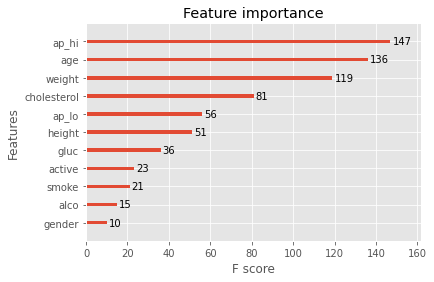

# feature engineering

dropping the id column as it's meaningless

In [ ]:
data.drop('id' , axis = 1 , inplace = True)

adding the body mass which is  weight / height squared in meters

In [ ]:
data['body_mass'] = data.weight / ((data.height)/100)**2

body mass less than 18 is underweight, from 18 to 27 is healthy, from 27 to 30 is overweight and more than 30 is severe overweight

[based on information from here](https://www.nhs.uk/common-health-questions/lifestyle/what-is-the-body-mass-index-bmi/)

In [ ]:
def get_body_mass_type(body_mass) :
  if body_mass < 18 :
    return 'underweight'
  elif body_mass <= 27 : # relaxing this threshold a liitle bit
    return 'healthy' 
  elif body_mass <= 30 :
    return 'overweight'
  else :
    return 'sever_overweight'     

In [ ]:
data['body_mass_type'] = data['body_mass'].apply(lambda m: get_body_mass_type(m))  # take the bodymass and return it's type
data

adding the level of the blood pressure 

[based on information from here](https://www.healthline.com/health/diastole-vs-systole#blood-pressure-ranges)

In [ ]:
def get_ap_type(row) :
  if ( (row.ap_hi <= 90) | (row.ap_lo <= 60) ) : # 90 or less high or 60 or less low
    return 'hypotension'
  elif ( (row.ap_hi <= 120) & (row.ap_lo <= 80) ) : # 120 or less high and 80 or less low
    return 'normal' 
  elif ( (row.ap_hi <= 129) & (row.ap_lo <= 80) ): # 120 to 129 high and 80 or less low
    return 'elevated'
  elif ( (row.ap_hi <= 139) | (row.ap_lo <= 89) ): # 130 to 139 high and 89 or less
    return 'stage1_hypertension'
  elif ( (row.ap_hi >= 180) | (row.ap_lo >= 120) ): # 180 or higher high and 120 or higher low
    return 'hypertensive_crisis'  
  else : # (less than 180 and greater than 139 high ) or/and (less than 120 and greater than 89 low)
    return 'stage2_hypertension'    
    

In [ ]:
data['ap_type'] = data.apply(get_ap_type , axis = 'columns')  
data

interaction variables

In [ ]:
import itertools
cat_features = ['cholesterol','gluc','smoke' ,'alco','active','body_mass_type','ap_type']
# Iterate through each pair of 2 features, combine them into interaction features
all_combinations = list(itertools.combinations(cat_features, 2))
for combination in all_combinations: #for each pair of columns convert them to strings then join them with the + operator.
  interaction = data[combination[0]].map(str) + '_' + data[combination[1]].map(str)
  interaction_name = combination[0] + '_' + combination[1]
  data[interaction_name] = interaction
data

Features encoding with one hot ecoding 

In [ ]:
#split the data after adding the new features
X_train , X_test, y_train, y_test = train_test_split(data.drop('cardio',axis = 1), data.cardio, train_size = 0.8 , random_state = random_state)

In [ ]:
cat_cols = list(X_train.select_dtypes(include = ['object']).columns) # getting the index of the categorical variables

OH_cols_train = pd.get_dummies(X_train[cat_cols]) 
OH_cols_test =  pd.get_dummies(X_test[cat_cols]) 

numerical_train = X_train.drop(cat_cols , axis = 1) # drop the categorical variables
numerical_test = X_test.drop(cat_cols , axis = 1) # drop the categorical variables

X_train = pd.concat([numerical_train , OH_cols_train], axis = 1 ) # add the new one hot encoded variables
X_test = pd.concat([numerical_test , OH_cols_test] , axis = 1) # add the new one hot encoded variables

In [ ]:
X_train

one hot encoding is not good in saving columns names

In [ ]:
set(X_train.columns) - set(X_test.columns)

In [ ]:
X_train.drop('body_mass_type_ap_type_underweight_elevated', axis = 1 , inplace = True)

any impact ? 

In [ ]:
xgb = XGBClassifier(n_jobs = -1 ,random_state=random_state  )
xgb.fit(X_train , y_train  )
preds = xgb.predict(X_test)
print("XGB accuracy is : " , " " , accuracy_score(preds , y_test) )


No there is not same accuracy `0.7355426074289876`

# Feature Selection

In [ ]:
sorted(list(xgb.feature_importances_) , reverse=True) 



```
# This is formatted as code
```

we will remove any feature its importanc less than or equal zero



In [ ]:
results=pd.DataFrame()
results['columns']=X_train.columns
results['importances'] = xgb.feature_importances_
results.sort_values(by='importances',ascending=False,inplace=True)
results.head(50)

In [ ]:
results = results[results.importances > 0]
selected_cols = list(results['columns'].values)
Final_X_train = X_train[selected_cols]
Final_X_test = X_test[selected_cols]

In [ ]:
Final_X_train

saving the final data set 

In [ ]:
Final_X_test.to_csv('Final_X_test.csv' , index = False)
y_test.to_csv('y_test.csv', index = False)

Final_X_train.to_csv('Final_X_train.csv', index = False)
y_train.to_csv('y_train.csv', index = False)

# Hyper paramter tuning

Check if the model is overfitting and determine the best number of estimators

In [ ]:
#splitting the data into train and validation set with the taget variable seperated 
X_train , X_val, y_train, y_val = train_test_split(Final_X_train, y_train, test_size =0.20 , random_state = random_state)

In [ ]:
from xgboost import XGBClassifier
eval_set = [(X_train , y_train),(X_val , y_val)]
xgb = XGBClassifier(n_jobs = -1 ,random_state=random_state   )
xgb.fit(X_train , y_train , eval_set= eval_set, verbose=True  , eval_metric='error' )
preds = xgb.predict(Final_X_test)
print("XGB accuracy is : " , " " , accuracy_score(preds , y_test) )

In [ ]:
pyplot.figure(figsize=(12,6))
results = xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot acuuracy
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='validation')
ax.legend()
pyplot.ylabel('error')
pyplot.title('XGBoost error')
pyplot.show()

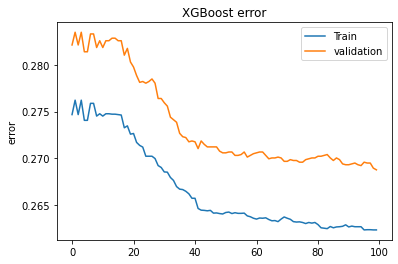

the model is not overfitting as we removed a lot of the columns

we will use early stopping to determine the number of epochs to stop at

In [ ]:
eval_set = [(X_val , y_val)]
xgb = XGBClassifier(n_jobs = -1 ,random_state=random_state , n_estimators= 1000 )
xgb.fit(X_train , y_train , eval_set= eval_set, verbose=True  , eval_metric='error' , early_stopping_rounds= 100)

Stopping. Best iteration:
[112]	validation_0-error:0.268663


apply extensive Grid search as the data is relatively small and as a final try to increase the accuracy

In [ ]:
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [112],
    'clf__learning_rate': [0.01,0.02, 0.05,0.1],
    'clf__max_depth': range(6, 10),
    'clf__colsample_bytree': [0.8 , 0.9 , 1],
    'clf__gamma': [i/10.0 for i in range(3)]
  }
]
# Define cross validation
kfold = KFold(n_splits=4, random_state=random_state)
# AUC and accuracy as score
#scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}
# Define grid search
grid = GridSearchCV(
  XGBClassifier(),
  param_grid=search_space,
  cv=kfold,
  scoring='accuracy',
  verbose=1,
  n_jobs=-1,
  refit = True
)


In [ ]:
grid.predict(Final_X_test)
print("XGB accuracy is : " , " " , accuracy_score(preds , y_test) )


[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed: 76.1min finished
XGB accuracy is :    0.7355426074289876

after very long grid search `76 mins` and 1125 different fit yet the model with the same accuracy... disappointing right ?

# Model explainability and interpretation ...

In [ ]:
plt.figure(figsize=(25,8))
plt.title("Features importance based on f1 score")
plt.xlabel("features")
plt.ylabel("inportance")
sns.barplot(x = results[:5]['columns'] , y = results[:5]['importances'] )

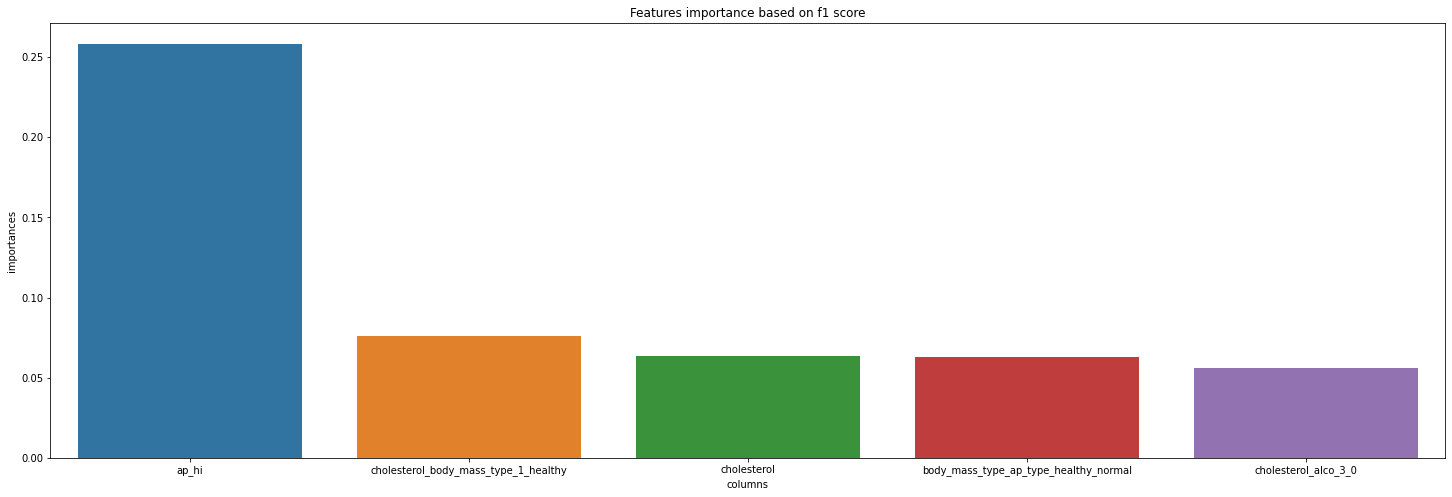

Confusion matrix using heatmap

In [ ]:
cm = confusion_matrix(y_test , preds)
f, ax = plt.subplots(figsize=(12,6))
sns.heatmap(cm,fmt=".0f", annot=True,linewidths=0.2, linecolor="purple", ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Grand Truth")
plt.show()

print('Report \n\n' , classification_report(y_test, preds) )



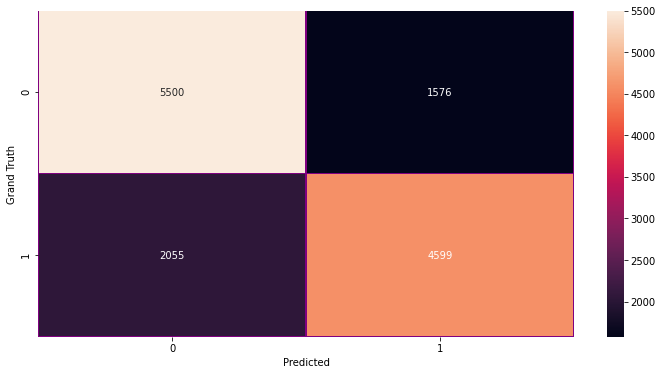

we can see that class zero has higher recall than the pecision which means that the model predict class zero relativly good but with a high false negative. for class 1 the model has percision more than the recall which means the model missed a lot of class 1 but when it predict 1 it do it relatively good

 [for more details](https://www.geeksforgeeks.org/confusion-matrix-machine-learning/)

our hypothesis for the reason of this is that the target variable class distribution `50% for 1` and `50% for 0` so we were expecting that the factors that increase the disease would have similar distribution so that all the 1 class would share things like **high glucose, smoking, not active, drink alchohol** and so on but this turned out not to be true ...

In [ ]:
plt.figure(figsize=(25,20))
df_long = pd.melt(data, id_vars=['cardio'], value_vars=['cholesterol','gluc', 'smoke', 'alco', 'active'])
sns.catplot(x="variable", hue="value", col="cardio",
                data=df_long, kind="count");
plt.show()                

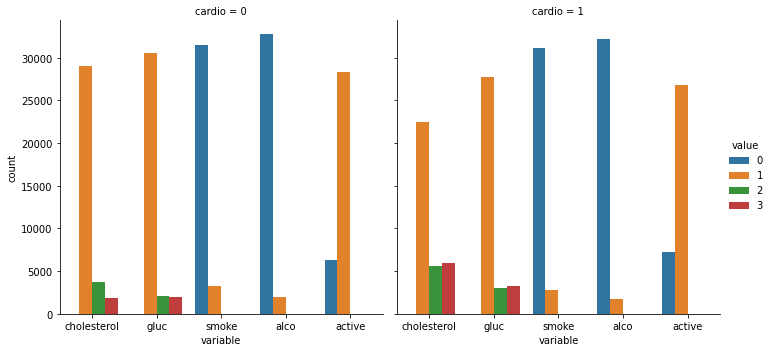

From this plot it's clear the the distribution of the important factors is `highly skewed` toward being `healthy` and having the disease which explains why the model has high `false negative` and smaller `false positive` as the data is baised toward being healthy , also these variable most of the time have the same value so the model is not learning so much from them 

In [ ]:
!pip install shap

In [ ]:
data = pd.read_csv('/content/data.csv')

In [ ]:
# i'm just taking 1% of the rows in the data set to make the shap values with as it takes forever with big data sets
X_train , X_test, y_train, y_test = train_test_split(data.drop('cardio',axis = 1), data.cardio, test_size  = 0.01 , random_state = 3)

In [ ]:
y_test.sum() / len(y_test) # we have the same distribuution but with smaller rows

In [ ]:
len(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rm = RandomForestClassifier(n_jobs = -1)
rm.fit(X_train , y_train )

In [ ]:
import shap
explainer = shap.TreeExplainer(rm)
shap_values = explainer.shap_values(X_test) # Create object that can calculate shap values
shap.summary_plot(shap_values[1], X_test) # get the values for class 1

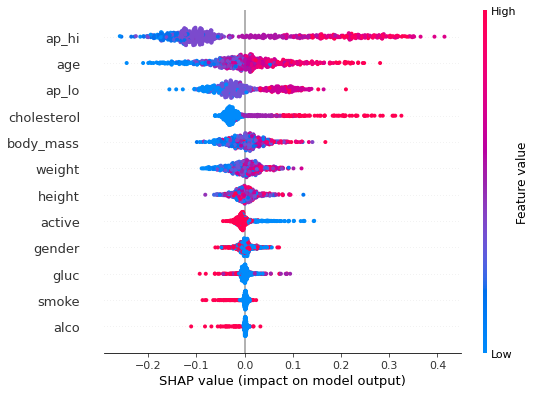

There is a lot of interesting info here

1. it's clear that the high preasure is very effective so that at high value the model increase the propability for class 1 and vice versa which is right 

2. on the other hand smoke variable is not important at all for the model when its value is zero as most of the values is zero for this variable so the target variable is changing while it's the same value and we see that when it's 1 the model deacrese the probability for having the disease! one  interpretation for this is that the number of persons smoke in and do not have a disease is bigger than who have which is misleading from the small number of smoking people in the data

3.  Almost the same problem applies for glu, alco 
2.   we can see a huge widespread for thee cholestrol although it has only 3 values so this is an indicator that it interact wiht another variable




In [ ]:
# i'm just taking 5% of the rows in the data set to make the shap values with as it takes forever with big data sets
X_train , _ , _, _ = train_test_split(X_train, y_train, train_size  = 0.01 , random_state = 3)

In [ ]:
len(X_train)

In [ ]:
import shap
explainer = shap.TreeExplainer(rm)
shap_values = explainer.shap_values(X_train) # Create object that can calculate shap values


In [ ]:
shap.dependence_plot('cholesterol' , shap_values[1], X_test, interaction_index = 'age')

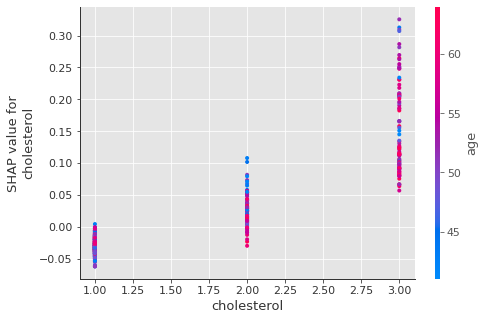

In [ ]:
plt.style.use('classic')
shap.dependence_plot('cholesterol' , shap_values[1], X_train)

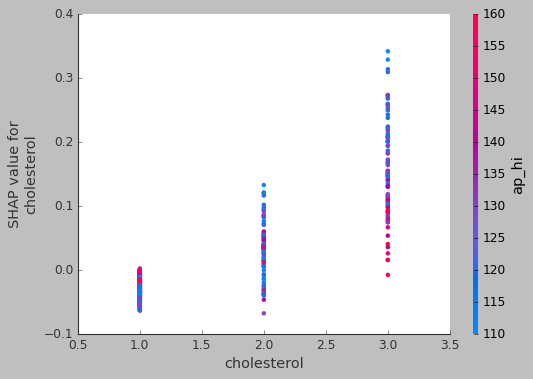

so the reason for the spread of the impact on the model for cholestrol is that it's effected by the age and presure so that when it's 3 and the age or pressure is high it increase the model probability to having the disease significantly which makes sense

# Final thoughts and conclusion

Data sience alwas has uncertinity sometimes your model do not get high accuracy but this does not mean the model  is bad you just need to know why this happend and as we already highlighted above about why the model is not achiving high accuracy we propose some solutions to this if we were in the real life: 

1. Talk with the data collectors to get more feature to help catch more about the real life behavior like family history for example
2. Making good randomization for the important features like smoking, gluc, alco , ect so that not being skewed toward a certain class to enable the model learning from them 
3. Retrain the model again after fixing the  
data problems




